In [7]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
from sklearn.metrics import f1_score
from fastai.vision.all import *
import lightgbm as lgb


In [8]:
if Path("/kaggle").exists():
    # This is in Kaggle
    initial_path = Path(
        "/kaggle", "input", "deforestation", "train_test_data", "train_test_data"
    )
    input_path = Path("/kaggle", "input", "deforestation")
    output_path = Path("/kaggle", "working")
    df_train = pd.read_csv(input_path / "train.csv")
    df_test = pd.read_csv(input_path / "test.csv")
else:
    initial_path = Path("data") / "train_test_data"
    input_path = Path("data")
    df_train = pd.read_csv(input_path / "train.csv")
    df_test = pd.read_csv(input_path / "test.csv")
    output_path = Path("artifacts")
    output_path.mkdir(exist_ok=True)

# Preprocess data
df_train["short_path"] = df_train["example_path"].apply(lambda x: Path(x).name)
df_test["short_path"] = df_test["example_path"].apply(lambda x: Path(x).name)
train_labels = {row["short_path"]: row["label"] for i, row in df_train.iterrows()}
train_image_path = initial_path / "train"

In [9]:
def label(file_name):
    return train_labels.get((Path(file_name)).name, 0)

In [10]:
f1_macro = F1Score(average='macro')

In [11]:
# Get image data
base_path = initial_path / "train"
test_path = initial_path / "test"

all_files = get_image_files(str(base_path))

# Image loader
all_dls = ImageDataLoaders.from_path_func(
    base_path,
    all_files,
    label_func=label,
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(size=224),
    valid_pct=0,
)

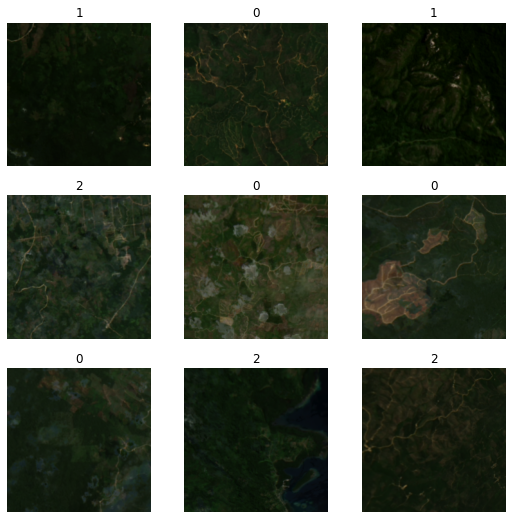

In [12]:
all_dls.show_batch()

In [13]:
# Create learner
learn = vision_learner(
    all_dls,
    resnet50,
    metrics=[error_rate, f1_macro],
    model_dir=output_path,
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


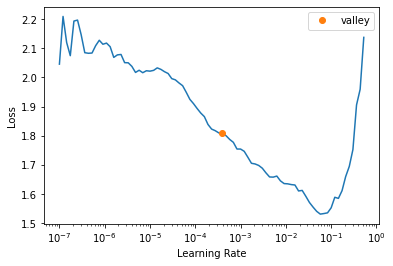

In [14]:
# Find optimal LR
lr = learn.lr_find()

In [15]:
# Train learner
learn.fine_tune(20, lr.valley)

epoch,train_loss,valid_loss,error_rate,f1_score,time
0,1.554072,None,None,None,00:13


epoch,train_loss,valid_loss,error_rate,f1_score,time
0,1.131813,None,None,None,00:15
1,1.114994,None,None,None,00:14
2,1.095553,None,None,None,00:15
3,1.035984,None,None,None,00:14
4,0.970321,None,None,None,00:15
5,0.887247,None,None,None,00:18
6,0.823178,None,None,None,00:21
7,0.783624,None,None,None,00:22
8,0.712992,None,None,None,00:21
9,0.653611,None,None,None,00:22


In [17]:
# Prepare data for lightgbm and train
X_train, y_train = df_train[['latitude','longitude','year']].copy(), df_train.label.copy()
X_test = df_test[['latitude','longitude','year']].copy()

model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

LGBMClassifier()

In [18]:
# Predict lightgbm probabilities
test_probas = model.predict_proba(X_test)
lightgbm_probas = pd.DataFrame(test_probas, columns = ['0','1','2'])
lightgbm_probas["short_path"] = df_test["short_path"].values

In [ ]:
# Predict nn probabilities
predictions = {}
scores = {}
for file in test_path.glob('*.png'):
    prediction = learn.predict(file)
    predictions[file.name] = prediction[0]
    scores[file.name] = prediction[2].numpy()

test_scores_nn = pd.DataFrame(scores).T.reset_index().rename(columns={"index": "short_path"})

In [21]:
# Ensemble nn and lightgbm
merged_probas = lightgbm_probas.merge(test_scores_nn, how="left")
ensemble_probas = merged_probas[["short_path"]].copy()
ensemble_probas.loc[:, 0] = (merged_probas[0] + merged_probas['0']) / 2
ensemble_probas.loc[:, 1] = (merged_probas[1] + merged_probas['1']) / 2
ensemble_probas.loc[:, 2] = (merged_probas[2] + merged_probas['2']) / 2
ensemble_probas["prediction"] = ensemble_probas.loc[:, [0, 1, 2]].idxmax(axis=1)

In [22]:
learn.export(output_path / "model.pkl")

In [29]:
final_test = (
    ensemble_probas
    .assign(short_path=lambda x: x.short_path.str.replace(".png", ""))
    .rename(columns={"prediction": "target"})
    .loc[:, ["short_path", "target"]]
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
(
    final_test
    .set_index("short_path")
    .to_json(output_path / "predictions.json")
)

In [32]:
final_test.set_index("short_path").to_csv(output_path / "predictions.csv")

Check that ensemble does similar things as individual models

In [47]:
test_scores_nn["prediction"] = test_scores_nn.drop(columns="short_path").idxmax(axis=1)


In [ ]:
lightgbm_probas["prediction"] = lightgbm_probas.drop(columns="short_path").idxmax(axis=1)

In [50]:
lightgbm_probas.merge(ensemble_probas, on="short_path").groupby(["prediction_x", "prediction_y"]).size()


prediction_x  prediction_y
0             0               279
              1                 3
              2                50
1             0                17
              1                38
              2                10
2             0                60
              1                 4
              2               174
dtype: int64

In [51]:
test_scores_nn.merge(ensemble_probas, on="short_path").groupby(["prediction_x", "prediction_y"]).size()

prediction_x  prediction_y
0             0               336
              1                10
              2                12
1             0                 6
              1                32
              2                 4
2             0                14
              1                 3
              2               218
dtype: int64